# Estimating Physics Parameters

Once clusters have been identified, the next step is to estimate the physics parameters which will be feed to the solver of choice (either ODE or Kalman filter). The main points are the initial orientation and energy of the particle, as well as the species of the particle. 

First we import our code

In [43]:
import sys
sys.path.append('..')
from pcutils.core.config import load_config
from pcutils.core.workspace import Workspace
from pcutils.core.point_cloud import PointCloud
from pcutils.core.clusterize import ClusteredCloud
from pcutils.core.estimator import estimate_physics, generate_circle_points
import h5py as h5
import matplotlib.pyplot as plt
import numpy.random as random
import numpy as np

Now that we have our modules, we need to load our configuration and workspace, as usual. Here we also load up a result container that we will use with our code.

In [44]:
config = load_config('../config.json')
ws = Workspace(config.workspace)

results: dict[str, list] = {'event': [], 'cluster_index': [], 'cluster_label': [], 'vertex_x': [], 'vertex_y': [], 'vertex_z': [],\
                             'center_x': [], 'center_y': [], 'center_z': [], 'polar': [], 'azimuthal': [],\
                             'brho': [], 'dEdx': [], 'dE': [], 'arclength': [], 'direction': []}

From our workspace we can then request the file for our clusters, and read in a random cluster from the file

In [49]:
run_number = 4
cluster_file = h5.File(ws.get_cluster_file_path(run_number))
cluster_group = cluster_file['cluster']
min_event = cluster_group.attrs['min_event']
max_event = cluster_group.attrs['max_event']
print(min_event, max_event)
event_group = None
event = 0
nclusters = 0
while(True):
    event = np.random.randint(min_event, max_event)
    #event = 2510
    try:
        event_group = cluster_group[f'event_{event}']
        nclusters = event_group.attrs['nclusters']
        if nclusters != 0:
            break
    except:
        continue
local_cluster = None
cluster_index = np.random.randint(0, nclusters)
local_cluster = event_group[f'cluster_{cluster_index}']

print(f'event: {event}')
print(f'cluster index: {cluster_index}')
cluster = ClusteredCloud()
cluster.label = local_cluster.attrs['label']
cluster.point_cloud = PointCloud()
cluster.point_cloud.load_cloud_from_hdf5_data(local_cluster['cloud'][:].copy(), event)

2 26235
event: 3575
cluster index: 0


With our cluster selected and loaded, we can now send it, along with some configuration paramters, through the estimator code.

In [50]:
estimate_physics(cluster_index, cluster, config.estimate, config.detector, results)

Now we can look at some of our results! First we'll look at the circle fit, and the estimated vertex poistion, which is how we estimate $B\rho$. We'll also draw a line corresponding to the estimated initial direction

0.2877401088879652
96.92103068691978


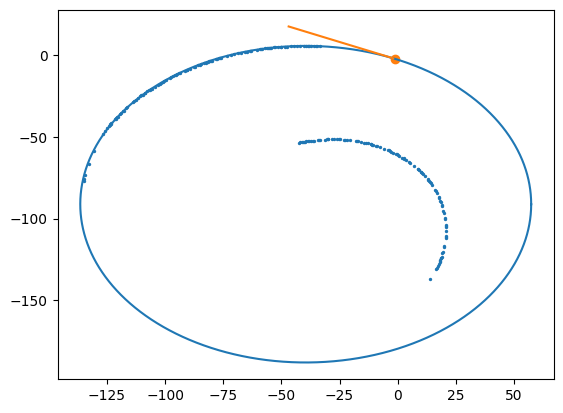

In [51]:
center_x = results['center_x'][-1]
center_y = results['center_y'][-1]
vertex_x = results['vertex_x'][-1]
vertex_y = results['vertex_y'][-1]
theta = results['polar'][-1]
phi = results['azimuthal'][-1]
brho = results['brho'][-1]
rho_mm = brho/config.detector.magnetic_field * 1000.0 * np.sin(theta)
print(brho)
print(rho_mm)
length_samples = np.linspace(1.0, 50.0, 50)
dir_x_samples = length_samples * np.cos(phi) + vertex_x
dir_y_samples = length_samples * np.sin(phi) + vertex_y

circle_points = generate_circle_points(center_x, center_y, rho_mm)
plt.scatter(cluster.point_cloud.cloud[:, 0], cluster.point_cloud.cloud[:, 1], label='cluster', s=2)
plt.plot(circle_points[:, 0], circle_points[:, 1], label='circle')
plt.scatter(vertex_x, vertex_y, label='vertex')
plt.plot(dir_x_samples, dir_y_samples, label='direction')
plt.show()

We can also start building up a particle id using $B\rho$ and $\frac{dE}{dx}$. If you run the three cells above this repeatedly, you'll see the plot below fill with data!

{'event': [19508, 3575], 'cluster_index': [0, 0], 'cluster_label': [1, 2], 'vertex_x': [3.7970944032360485, -0.9799146003784855], 'vertex_y': [14.867520945650575, -2.2652894117040887], 'vertex_z': [665.7568928225079, 493.75740903878096], 'center_x': [19.342385246740086, -39.52115802386467], 'center_y': [75.7252218374067, -91.19368051818047], 'center_z': [665.7568928225079, 493.75740903878096], 'polar': [0.5713600821886474, 1.3550758008111339], 'azimuthal': [6.03309632310073, 2.7326317402996088], 'brho': [0.33683793107711313, 0.2877401088879652], 'dEdx': [3267.7359107903217, 3168.3407298191123], 'dE': [914152.1684374157, 468370.8126532793], 'arclength': [279.7509325704116, 147.82842269619772], 'direction': [0, 0]}


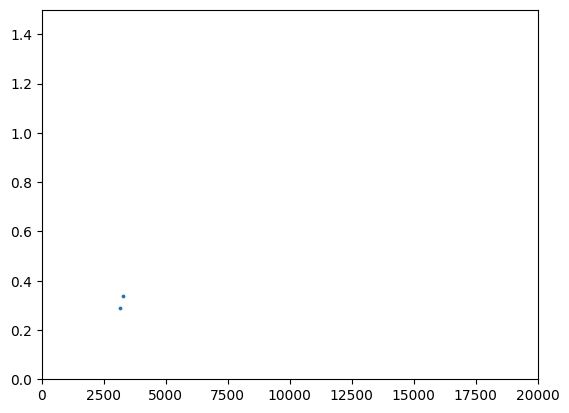

In [52]:
plt.scatter(results['dEdx'], results['brho'], s=3)
plt.xlim(0, 20000)
plt.ylim(0, 1.5)